# Base Analysis of Game vs Stockfish.
- For one of the players.
- Look at the top moves in any given position.
- Look at the +/- of the move they made.

In [1]:
import pandas as pd
import numpy as np

import chess
import chess.pgn
from stockfish import Stockfish
stockfish = Stockfish(path="/usr/games/stockfish", depth=5, parameters={"Threads": 32, "Minimum Thinking Time": 5})

from tqdm.notebook import tqdm, trange

import seaborn as sns
import matplotlib.pyplot as plt

## Load FENS of a Player

In [288]:
# !grep -Hnr pgns/Kaidanov.pgn
!sed '1890,1892!d' pgns/Kaidanov.pgn

[ECO "C83"]

1.e4 e5 2.Nf3 Nc6 3.Bb5 a6 4.Ba4 Nf6 5.O-O Nxe4 6.d4 b5 7.Bb3 d5 8.dxe5 Be6


In [10]:
def get_games_df(pgn_file):
    try:
        with open(pgn_file, mode='r', encoding="utf-8") as pgn:
            pgn = pgn.readlines()
        ngames = len([c for c in pgn if 'Event' in c])
    except:
        ngames= 100_000
        
    headers = []
    games = []
    with open(pgn_file, mode='r', encoding="utf-8") as pgn:
        for _ in trange(ngames):
            try:
                header = chess.pgn.read_headers(pgn)
                if header is None:
                    break
                headers.append(header)
                games.append(chess.pgn.read_game(pgn))
            except:
                break
    headers_df = pd.DataFrame(headers)
    games_df = headers_df.merge(pd.DataFrame(games).rename(columns={0:'game'}), left_index=True, right_index=True)
    return games_df

In [11]:
games_df = get_games_df("pgns/Kasparov.pgn")

  0%|          | 0/100000 [00:00<?, ?it/s]

# Loop through moves in the game

In [12]:
def get_move_ranks(game, player, disable_tqdm=True):
    board = game.board()
    top_moves = []
    evaluations = []

    mainline = game.mainline_moves()
    n_moves = len([g for g in mainline])


    move_number = 0
    move_ranks = []
    moves = []

    if game.headers['White'] == player:
        is_white = True
    elif game.headers['Black'] == player:
        is_white = False
    else:
        print('Player not in either black or white position')
        print(game.headers['White'])
        print(game.headers['Black'])
        return pd.DataFrame()

    for move in tqdm(game.mainline_moves(), total=n_moves, disable=disable_tqdm):
        move_number += 1
        board.push(move)
        if (move_number <= 20):
            # stockfish.set_fen_position(board.fen())
            top_moves.append([])
            evaluations.append(np.nan)
        if (move_number == 1):
            stockfish.set_fen_position(board.fen())
            top_moves.append(stockfish.get_top_moves(10))
            evaluations.append(stockfish.get_evaluation())
        # only evaluate player move
        elif ((move_number % 2 == 1) and is_white) | ((move_number % 2 != 1) and not is_white):
            moves.append(str(move))
            current_move_rank = np.nan
            for rank, m in enumerate(top_moves[-1]):
                if m['Move'] == str(move):
                    current_move_rank = rank + 1
            move_ranks.append(current_move_rank)

        else:
            stockfish.set_fen_position(board.fen())
            top_moves.append(stockfish.get_top_moves(10))
            evaluations.append(stockfish.get_evaluation())
    move_ranks_df = pd.DataFrame(data=np.array([moves, move_ranks]).T, columns=['move','move_rank'])
    move_ranks_df = pd.concat([move_ranks_df, pd.DataFrame(top_moves[1:])], axis=1)
    return move_ranks_df

In [19]:
player = 'Kasparov,G'
games_move_ranks_df = []
for i, row in tqdm(games_df[-100:].iterrows(), total=len(games_df[-100:])):
    g = row['game']
    move_ranks_df = get_move_ranks(g, player)
    move_ranks_df['game'] = g
    games_move_ranks_df.append(move_ranks_df)

  0%|          | 0/100 [00:00<?, ?it/s]

In [28]:
results = {}

Text(0.5, 1.0, 'Kasparov,G Move rank vs move number')

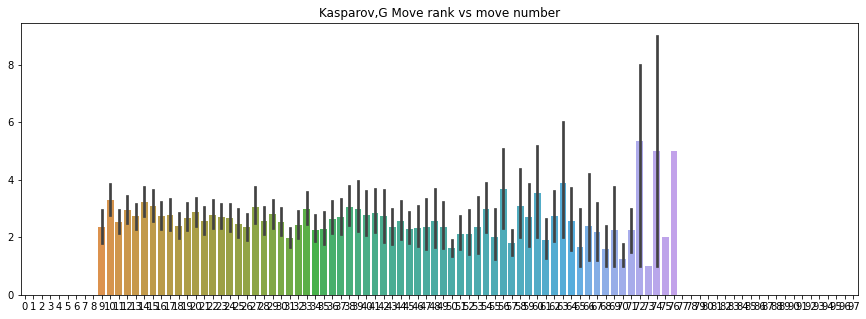

In [56]:
move_ranks = [g['move_rank'].astype('float') for g in games_move_ranks_df]
df = pd.DataFrame(move_ranks)

df_temp = df.T[10:].T.copy()
df_temp.index = games_df[-100:]['game']

results[player] = df_temp

fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(data=df, ax=ax)
ax.set_title(player + ' Move rank vs move number')

<AxesSubplot:title={'center':'Distribution of Kasparov,G Last 100 Games Move Rank (Move 10+)'}, ylabel='Frequency'>

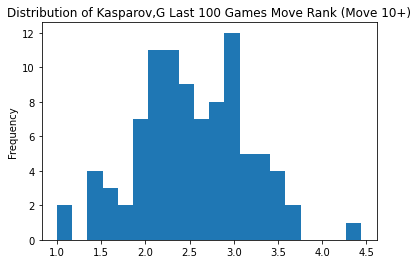

In [25]:
df.T[20:].T.mean(axis=1).plot(kind='hist', bins=20, title=f'Distribution of {player} Last 100 Games Move Rank (Move 10+)')

Text(0.5, 1.0, 'Kasparov,G: Moves vs Move Rank')

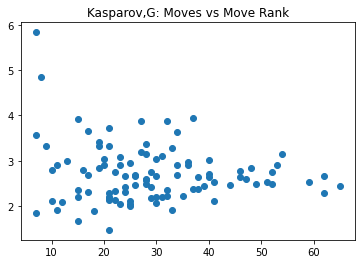

In [27]:
n_moves = (~df.isna()).sum(axis=1)
fig, ax= plt.subplots()
plt.scatter(x=n_moves,
            y=df.T[10:].T.mean(axis=1).values)
ax.set_title(f'{player}: Moves vs Move Rank')

# Magnus

In [57]:
games_df = get_games_df("pgns/Carlsen.pgn")

  0%|          | 0/4314 [00:00<?, ?it/s]

In [58]:
games_df['game'][0]

<Game at 0x7f4dcc541bb0 ('Carlsen,Magnus' vs. 'Brameld,A', '2001.01.06')>

In [62]:
player = 'Carlsen,M'
games_move_ranks_df = []
for i, row in tqdm(games_df[-100:].iterrows(), total=len(games_df[-100:])):
    g = row['game']
    move_ranks_df = get_move_ranks(g, player)
    move_ranks_df['game'] = g
    games_move_ranks_df.append(move_ranks_df)

  0%|          | 0/100 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Carlsen,M Move rank vs move number')

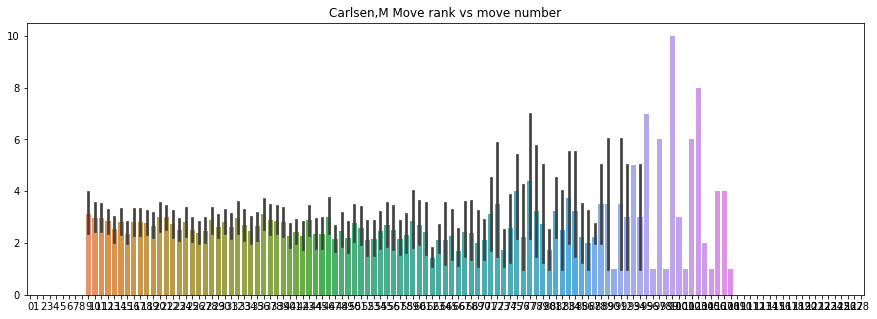

In [63]:
move_ranks = [g['move_rank'].astype('float') for g in games_move_ranks_df]
df = pd.DataFrame(move_ranks)

df_temp = df.T[10:].T.copy()
df_temp.index = games_df[-100:]['game']

results[player] = df_temp

fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(data=df, ax=ax)
ax.set_title(player + ' Move rank vs move number')

<AxesSubplot:title={'center':'Distribution of Magnus Last 20 Games Move Rank (Move 10+)'}, ylabel='Frequency'>

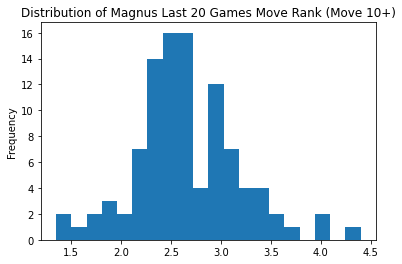

In [64]:
df.T[10:].T.mean(axis=1).plot(kind='hist', bins=20, title='Distribution of Magnus Last 20 Games Move Rank (Move 10+)')

In [65]:
n_moves = (~df.isna()).sum(axis=1)

Text(0.5, 1.0, 'Carlsen,M: Moves vs Move Rank')

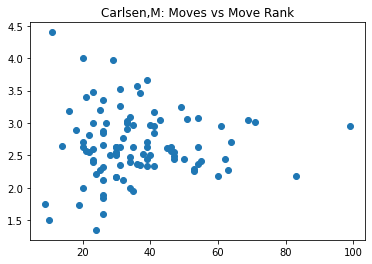

In [66]:
fig, ax= plt.subplots()
plt.scatter(x=n_moves,
            y=df.T[10:].T.mean(axis=1).values)
ax.set_title(f'{player}: Moves vs Move Rank')

# Same thing for Fabi

In [67]:
games_df = get_games_df("pgns/Caruana.pgn")

player = 'Caruana,F'
games_move_ranks_df = []
for i, row in tqdm(games_df[-100:].iterrows(), total=len(games_df[-100:])):
    g = row['game']
    move_ranks_df = get_move_ranks(g, player)
    move_ranks_df['game'] = g
    games_move_ranks_df.append(move_ranks_df)


  0%|          | 0/3429 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Player not in either black or white position
?
?


In [69]:
move_ranks = [g['move_rank'].astype('float') for g in games_move_ranks_df[:-1]]
df = pd.DataFrame(move_ranks)

df_temp = df.T[10:].T.copy()
df_temp.index = games_df[-100:-1]['game']

results[player] = df_temp

Text(0.5, 1.0, 'Caruana,F Move rank vs move number')

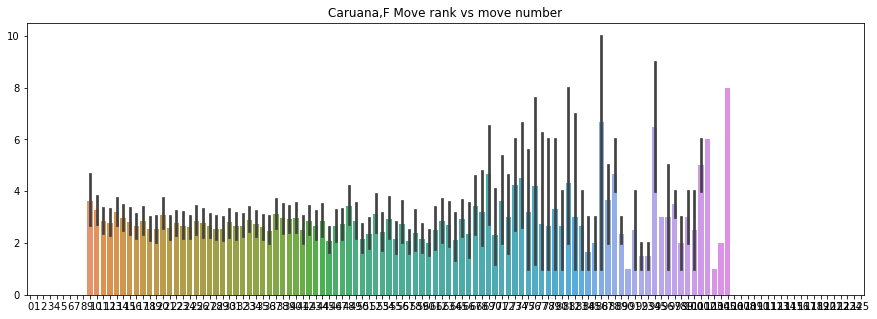

In [70]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(data=df, ax=ax)
ax.set_title(player + ' Move rank vs move number')

<AxesSubplot:title={'center':'Distribution of Fabi Last 20 Games Move Rank (Move 10+)'}, ylabel='Frequency'>

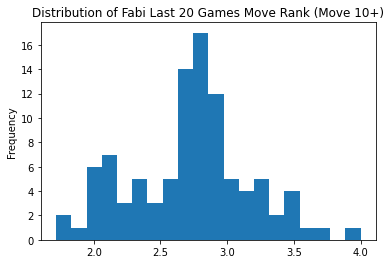

In [71]:
df.T[10:].T.mean(axis=1).plot(kind='hist', bins=20, title='Distribution of Fabi Last 20 Games Move Rank (Move 10+)')

Text(0.5, 1.0, 'Caruana,F: Moves vs Move Rank')

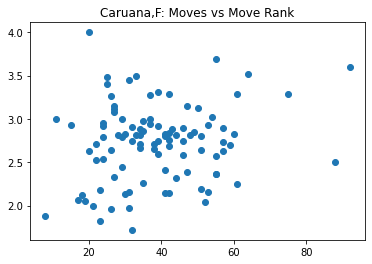

In [72]:
n_moves = (~df.isna()).sum(axis=1)
fig, ax= plt.subplots()
plt.scatter(x=n_moves,
            y=df.T[10:].T.mean(axis=1).values)
ax.set_title(f'{player}: Moves vs Move Rank')

In [74]:
results.keys()

dict_keys(['Kasparov,G', 'Carlsen,M', 'Caruana,F'])

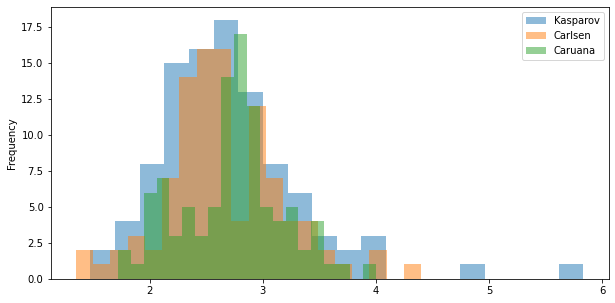

In [97]:
fig, ax = plt.subplots(figsize=(10, 5))
results['Kasparov,G'].mean(axis=1).plot(kind='hist', label='Kasparov', bins=20, alpha=0.5)
results['Carlsen,M'].mean(axis=1).plot(kind='hist', label='Carlsen', bins=20, alpha=0.5)
results['Caruana,F'].mean(axis=1).plot(kind='hist', label='Caruana', bins=20, alpha=0.5)
plt.legend()

In [119]:
pal = sns.color_palette()

Exception ignored in: <function Stockfish.__del__ at 0x7f4e6a5c61f0>
Traceback (most recent call last):
  File "/home/robmulla/anaconda3/envs/kaggle2/lib/python3.8/site-packages/stockfish/models.py", line 757, in __del__
    if self._stockfish.poll() is None:
AttributeError: 'Stockfish' object has no attribute '_stockfish'
Exception ignored in: <function Stockfish.__del__ at 0x7f4e6a5c61f0>
Traceback (most recent call last):
  File "/home/robmulla/anaconda3/envs/kaggle2/lib/python3.8/site-packages/stockfish/models.py", line 757, in __del__
    if self._stockfish.poll() is None:
AttributeError: 'Stockfish' object has no attribute '_stockfish'


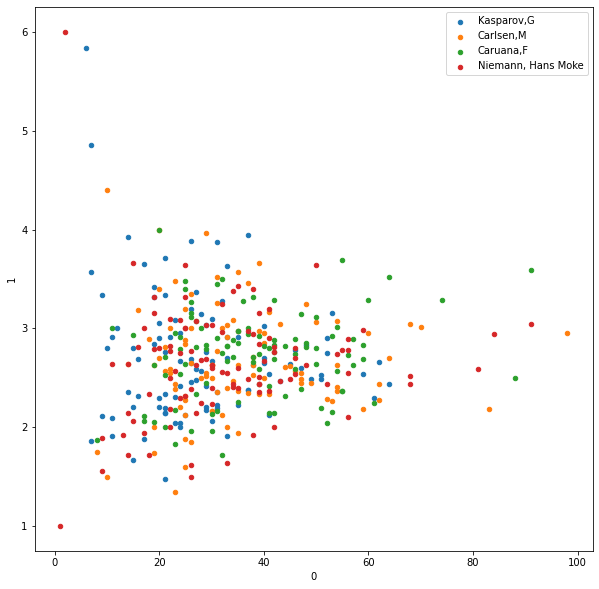

In [289]:
fig, ax = plt.subplots(figsize=(10, 10))
idx = 0
for i, d in results.items():
    pd.DataFrame([(~d.isna()).sum(axis=1), d.mean(axis=1)]).T.plot(x=0, y=1, kind='scatter', ax=ax, label=i, color=pal[idx])
    idx += 1

# Hans

In [282]:
# games_df = games_df.sort_values('Date').reset_index(drop=True)
# games_df['site'] = games_df['game'].apply(lambda x: x.headers['Site'])
# games_df['online'] = games_df['site'].str.contains('.com')

In [305]:
# games_df['game'].values

In [290]:
games_df = get_games_df("pgns/niemann.pgn")
games_df = games_df.dropna(subset=['game'])


games_df = games_df.sort_values('Date').reset_index(drop=True)
games_df['site'] = games_df['game'].apply(lambda x: x.headers['Site'])
games_df['online'] = games_df['site'].str.contains('.com')

player = 'Niemann, Hans Moke'
games_move_ranks_df = []
for i, row in tqdm(games_df[-100:].iterrows(), total=len(games_df[-100:])):
    g = row['game']
    move_ranks_df = get_move_ranks(g, player)
    move_ranks_df['game'] = g
    games_move_ranks_df.append(move_ranks_df)


  0%|          | 0/8539 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [291]:
move_ranks = [g['move_rank'].astype('float') for g in games_move_ranks_df]
df = pd.DataFrame(move_ranks)

df_temp = df.T[10:].T.copy()
df_temp.index = games_df[-100:]['game']

results[player] = df_temp

Text(0.5, 1.0, 'Niemann, Hans Moke Move rank vs move number')

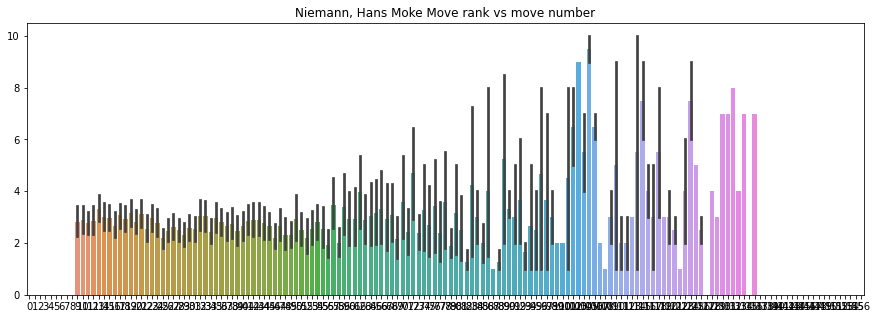

In [292]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(data=df, ax=ax)
ax.set_title(player + ' Move rank vs move number')

<AxesSubplot:title={'center':'Distribution of Hans Last 20 Games Move Rank (Move 10+)'}, ylabel='Frequency'>

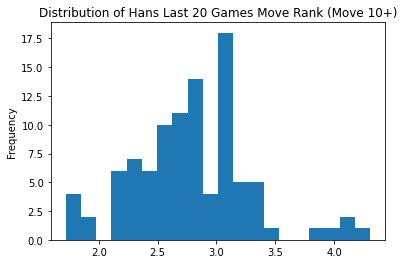

In [307]:
df.T[10:].T.mean(axis=1).plot(kind='hist', bins=20, title='Distribution of Hans Last 20 Games Move Rank (Move 10+)')

Text(0.5, 1.0, 'Niemann, Hans Moke: Moves vs Move Rank')

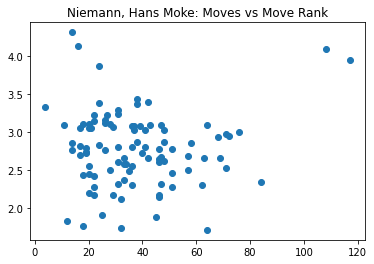

In [308]:
n_moves = (~df.isna()).sum(axis=1)
fig, ax= plt.subplots()
plt.scatter(x=n_moves,
            y=df.T[10:].T.mean(axis=1).values)
ax.set_title(f'{player}: Moves vs Move Rank')

In [309]:
dout = pd.DataFrame([(~d.isna()).sum(axis=1), d.mean(axis=1)]).T

/tmp/ipykernel_668416/3206684631.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  dout = pd.DataFrame([(~d.isna()).sum(axis=1), d.mean(axis=1)]).T


In [310]:
dout['online'] = dout.apply(lambda x: "com" in str(x.index), axis=1)

In [314]:
game = dout.index[0]

In [315]:
for i, d in dout.iterrows():
    dout.loc[i, 'site'] = i.headers['Site']

In [316]:
dout['online'] = dout['site'].str.contains('.com')

In [321]:
# fig, ax = plt.subplots()

# idx = 0
# for i, d in dout.groupby('online'):
#     d.plot(x=0, y=1, kind='scatter', ax=ax, label=i, color=pal[idx])
#     idx += 1

In [253]:
results.keys()

dict_keys(['Kasparov,G', 'Carlsen,M', 'Caruana,F', 'Niemann, Hans Moke'])

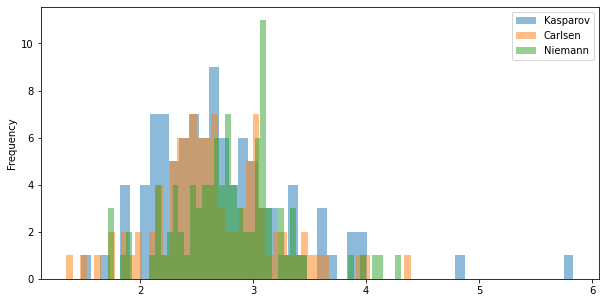

In [322]:
fig, ax = plt.subplots(figsize=(10, 5))
results['Kasparov,G'].mean(axis=1).plot(kind='hist', label='Kasparov', bins=50, alpha=0.5)
results['Carlsen,M'].mean(axis=1).plot(kind='hist', label='Carlsen', bins=50, alpha=0.5)
# results['Caruana,F'].mean(axis=1).plot(kind='hist', label='Caruana', bins=50, alpha=0.5)
results['Niemann, Hans Moke'].mean(axis=1).plot(kind='hist', label='Niemann', bins=50, alpha=0.5)

plt.legend()

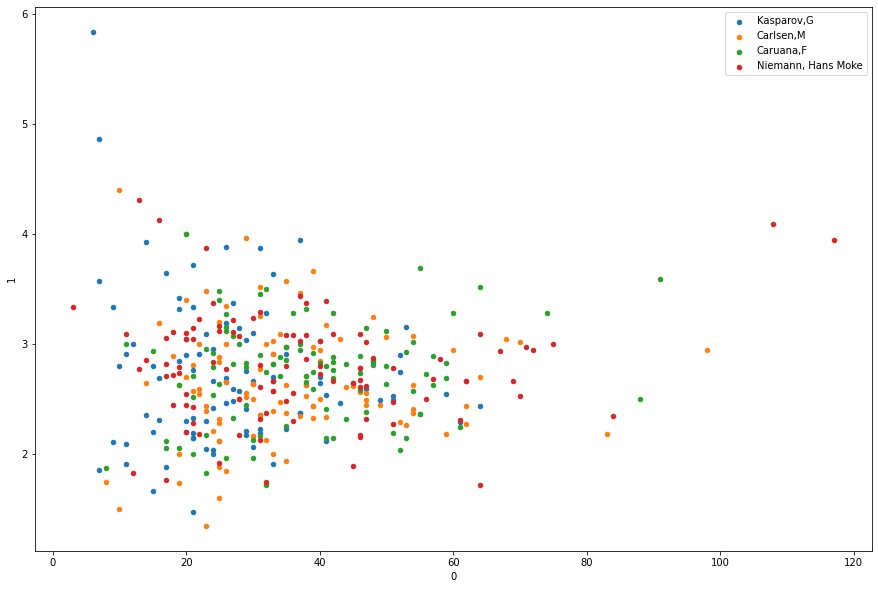

In [323]:
fig, ax = plt.subplots(figsize=(15, 10))
idx = 0
for i, d in results.items():
    pd.DataFrame([(~d.isna()).sum(axis=1), d.mean(axis=1)]).T.plot(x=0, y=1, kind='scatter', ax=ax, label=i, color=pal[idx])
    idx += 1